# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/programming projects/SAM'

/content/drive/MyDrive/programming projects/SAM


In [3]:
!pwd

/content/drive/MyDrive/programming projects/SAM


In [4]:
import os

import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [5]:
def get_image_from_files(dir):
  images_list = list()
  for root, dirs, files in os.walk(dir):
    for file in files:
      images_list.append(dir+file)
  print(f'There are {len(images_list)} images in our dataset')
  return images_list

dir = "dataset/"
images_list = get_image_from_files(dir)
image_path = dir + 'lake.JPG'

There are 16 images in our dataset


In [6]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [7]:
using_colab = False # Using colab but have downloaded sam_vit_h_4b8939.pth, set false
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Obtain Depth

In [8]:
raw_image = cv2.imread(image_path)
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [9]:
encoder = 'vitb' # can also be 'vits', 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
%%time
image_resized = transform({'image': raw_image})['image']
image_resized = torch.from_numpy(image_resized).unsqueeze(0)

depth = depth_anything(image_resized)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 8.98 s, sys: 4.54 s, total: 13.5 s
Wall time: 3.59 s


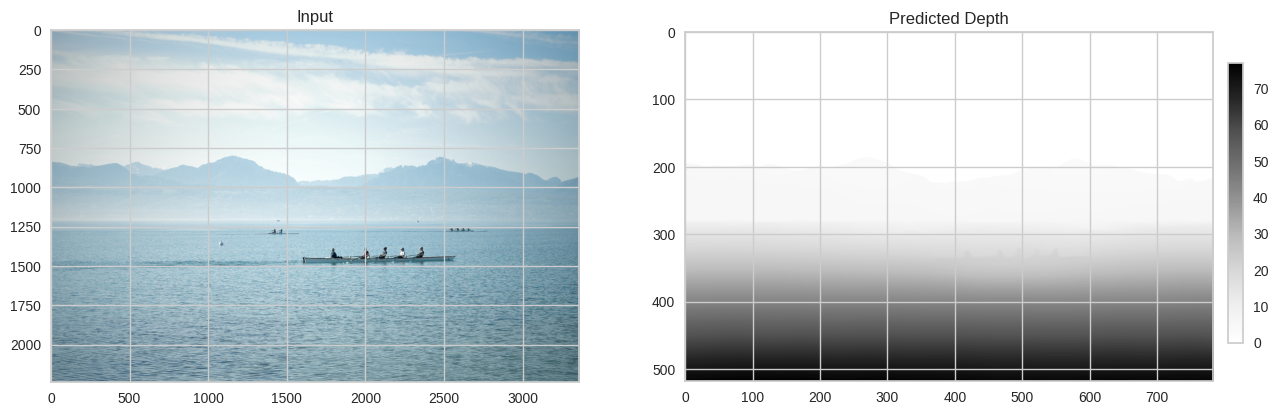

In [11]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

# Automatic segmentation of all objects

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [13]:
# mask_generator = SamAutomaticMaskGenerator(sam) # snowmountain
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=14) # snowmountain2
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=64) # morges-tulip #
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=64) # summer
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=18) # spring
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=18) # spring2 #
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=40) # lake
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=12) # garden-cat
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=64) #harbor #
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=64) # torri
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=128) # flowers

## Functions

In [14]:
from viz import show_anns, show_all_segmts_ind, show_layers
from cut import assign2layers_kmeans
from process_segments import downsample_image_opencv, obtain_all_objects, fill_with_superpixels
from PIL import Image, ImageEnhance

## Procedure

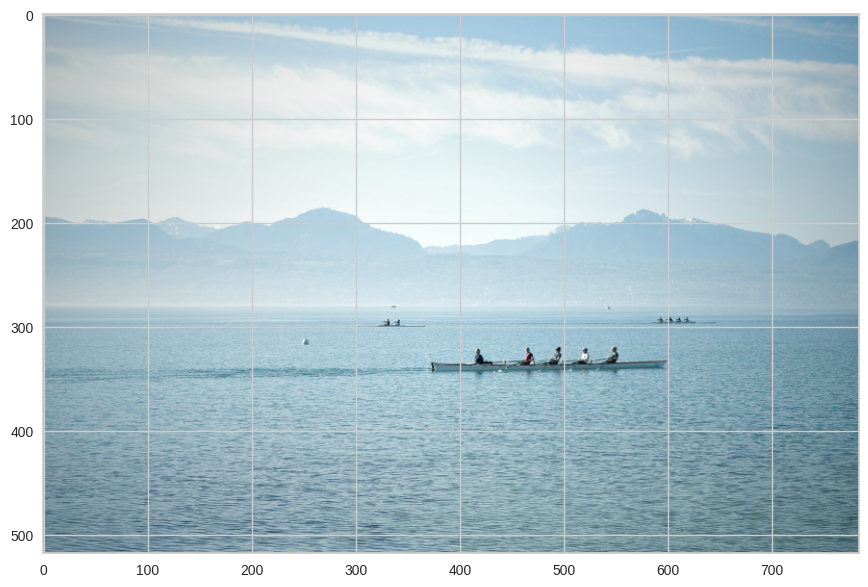

In [15]:
# Dowsample the original image
img_lr = downsample_image_opencv(raw_image, depth.shape)
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
plt.show()

In [16]:
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.05, small_thrd=500) # snowmountain
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.94, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # snowmountain2
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # morges-tulip #
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # summer
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.94, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # spring
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # spring2 #
object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.05, small_thrd=500) # lake
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # garden-cat
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # harbor #
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.89, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # torri
# object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.95, n_thrd = 10, ovlp_r_thrd=0.1, small_thrd=500) # flowers

Iteration n=1: white pixel raito after segmentation = 0.5
Iteration n=2: white pixel raito after segmentation = 0.97


There is 12 object masks


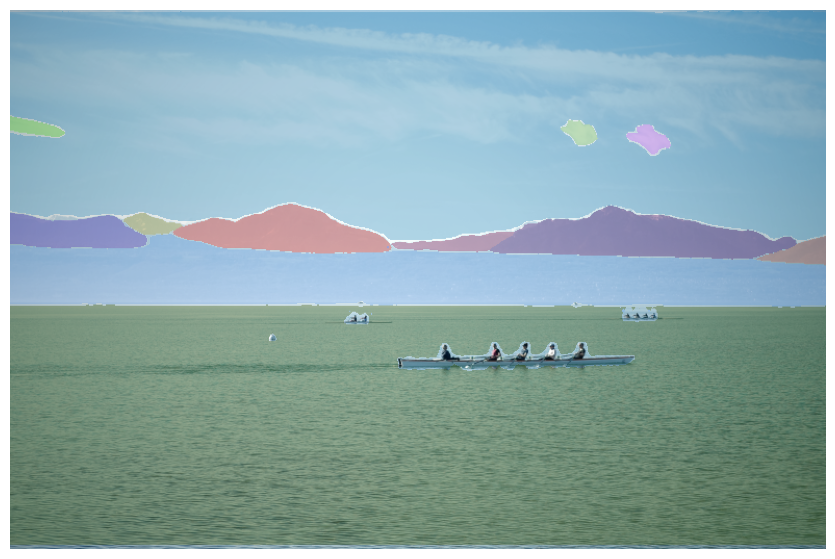

In [17]:
print(f"There is {len(object_masks)} object masks")
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(object_masks)
plt.axis('off')
plt.show()

In [18]:
new_object_masks = fill_with_superpixels(img_lr, object_masks)

There is 12 object masks


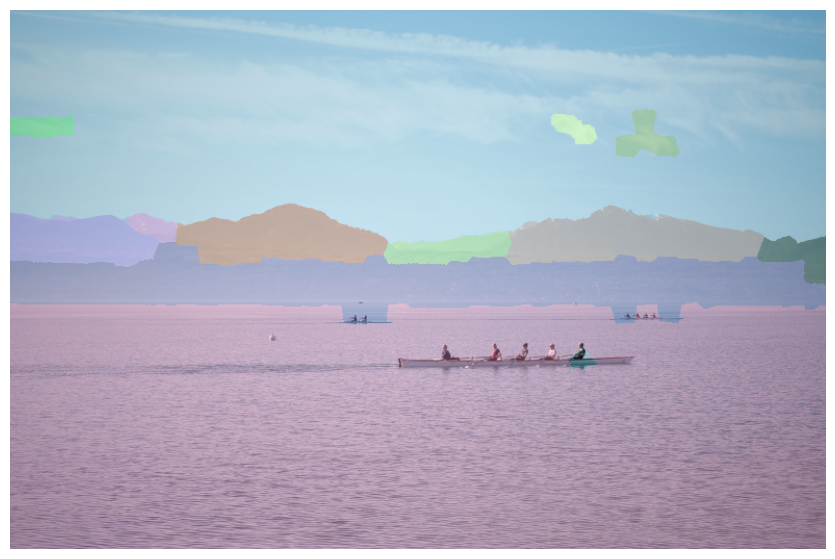

In [19]:
print(f"There is {len(new_object_masks)} object masks")
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(new_object_masks)
plt.axis('off')
plt.show()

In [20]:
# show_all_segmts_ind(object_masks, img_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

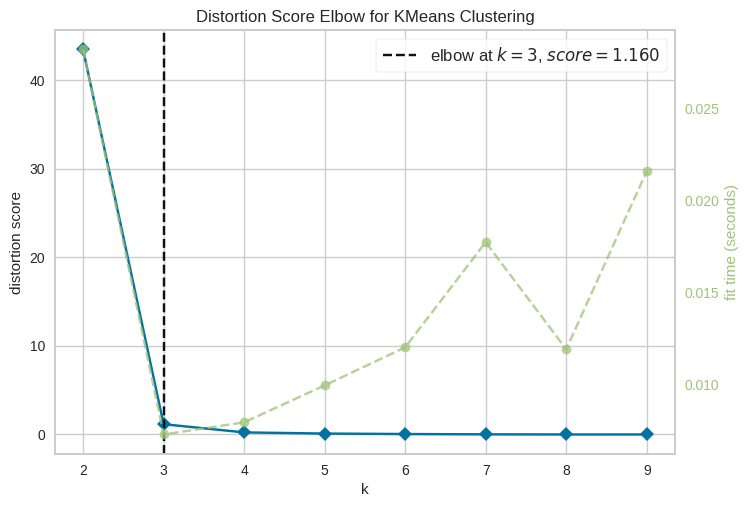

Optimal number of clusters: 3


In [21]:
depth_features = []
for m in object_masks:
  mask = m['segmentation']
  mask_tensor = torch.tensor(mask, dtype=torch.bool)
  mask_depth = depth[mask_tensor]
  if mask_depth.numel() > 0:
    average_depth = torch.mean(mask_depth.float())
    depth_features.append([average_depth.item()])

depth_features = np.array(depth_features)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=True)
visualizer.fit(depth_features)
visualizer.show()

optimalK = visualizer.elbow_value_
print(f"Optimal number of clusters: {optimalK}")


# Assign objects to layers based on depth

In [22]:
layers_idx, layers, layer_depth = assign2layers_kmeans(object_masks, depth.numpy(), optimalK)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


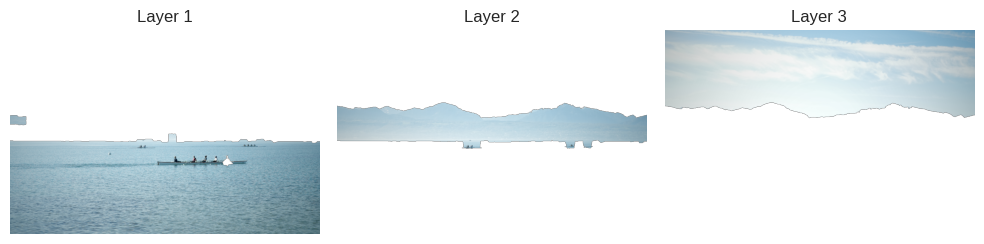

In [23]:
show_layers(img_lr, object_masks, layers_idx)

# Save data

In [82]:
pxl_layer1 = [ob['segmentation'] for ob in layers[0]]
pxl_layer2 = [ob['segmentation'] for ob in layers[1]]
pxl_layer3 = [ob['segmentation'] for ob in layers[2]]
# pxl_layer4 = [ob['segmentation'] for ob in layers[3]]
# summer_layer5 = [ob['segmentation'] for ob in layers[4]]

In [83]:
with open('./output/lake_layer1_segs.npy', 'wb') as f:
  np.save(f,pxl_layer1)

with open('./output/lake_layer2_segs.npy', 'wb') as f:
  np.save(f,pxl_layer2)

with open('./output/lake_layer3_segs.npy', 'wb') as f:
  np.save(f,pxl_layer3)

# with open('./output/pxl_layer4_segs.npy', 'wb') as f:
#   np.save(f,pxl_layer4)

# with open('./output/summer_layer5_segs.npy', 'wb') as f:
#   np.save(f,summer_layer5)